In [1]:
import pandas as pd
import numpy as np
import itertools
import igraph
import sys
import collections
import datetime
import random

In [2]:
G = igraph.Graph.Read_GraphML(f = 'networks/AM-TE-16-10.graphml')

In [6]:
period = 'raw_am'

In [4]:
od_data = pd.read_csv('TTS OD/LICO_TTS.csv')
od_data['origin'] = od_data['origin'] + 1000
od_data['destination'] = od_data['destination'] + 1000
od_data

,origin,destination,type,total
0,1001,1018,raw_am,15
1,1001,1035,raw_am,14
2,1001,1057,raw_am,20
3,1001,1068,raw_am,14
4,1001,1212,raw_am,8
...,...,...,...,...
30463,1603,1223,c0_ev,8
30464,1610,1561,c0_ev,22
30465,1613,1523,c0_ev,21
30466,1613,1578,c0_ev,47


In [5]:
stop_times_od = pd.read_csv('networks/AM-TE-16-10.csv')[['INT_ID_o', 'INT_ID_d', 'route_short_name', 'node_o', 'node_d']]
stop_times_od = stop_times_od.rename(columns = {'route_short_name':'route'})
stop_times_od

,INT_ID_o,INT_ID_d,route,node_o,node_d
0,13467129.0,13466778.0,506,13467129-506-9-9,13466778-506-9-10
1,13466778.0,13466640.0,506,13466778-506-9-10,13466640-506-9-11
2,13466640.0,13466531.0,506,13466640-506-9-11,13466531-506-9-12
3,13466531.0,13466677.0,506,13466531-506-9-12,13466677-506-9-13
4,13466677.0,13466754.0,506,13466677-506-9-13,13466754-506-9-15
...,...,...,...,...,...
714482,13449259.0,13448840.0,35,13449259-35-8-59,13448840-35-9-0
714483,13448840.0,13448292.0,35,13448840-35-9-0,13448292-35-9-1
714484,13448292.0,13447884.0,35,13448292-35-9-1,13447884-35-9-2
714485,13447884.0,13447218.0,35,13447884-35-9-2,13447218-35-9-4


In [6]:
stop_times_od[['INT_ID_o', 'INT_ID_d', 'route']].drop_duplicates()

,INT_ID_o,INT_ID_d,route
0,13467129.0,13466778.0,506
1,13466778.0,13466640.0,506
2,13466640.0,13466531.0,506
3,13466531.0,13466677.0,506
4,13466677.0,13466754.0,506
...,...,...,...
708341,13447954.0,13447776.0,35
708342,13447776.0,13447351.0,35
708343,13447351.0,13447070.0,35
708344,13447070.0,13446896.0,35


In [7]:
bc_weighted = pd.read_csv('BC Results Notebooks/bc_weighted_edge.csv')
bc_weighted = bc_weighted[bc_weighted['type'] == period].sort_values(by = 'weighted', ascending = False
                                                                    ).reset_index().drop(columns = 'index')
bc_weighted

,INT_ID_o,INT_ID_d,route,weighted,type
0,106,105,1.0,1.477083e-08,raw_am
1,105,104,1.0,1.418664e-08,raw_am
2,218,217,2.0,1.156116e-08,raw_am
3,217,216,2.0,1.135727e-08,raw_am
4,104,103,1.0,1.111271e-08,raw_am
...,...,...,...,...,...
9739,20364357,13441651,102.0,1.488503e-14,raw_am
9740,13441776,13441912,102.0,1.488503e-14,raw_am
9741,13441683,13441776,102.0,1.488503e-14,raw_am
9742,13441912,13442251,102.0,1.488503e-14,raw_am


In [8]:
node_data = od_data[od_data['type'] == period][['origin', 'destination']].copy()
node_data['origin'] = node_data['origin'].astype(str)
node_data['destination'] = node_data['destination'].astype(str)

#node_data['o_node'] = node_data['origin'] + '-0' + rand_time[5]
#for limit testing
node_data['o_node'] = node_data['origin'] + '-0-7-59'

node_data['d_node'] = node_data['destination'] + '-0-99-99'
node_data = node_data.reset_index()
node_data

,index,origin,destination,o_node,d_node
0,0,1001,1018,1001-0-7-59,1018-0-99-99
1,1,1001,1035,1001-0-7-59,1035-0-99-99
2,2,1001,1057,1001-0-7-59,1057-0-99-99
3,3,1001,1068,1001-0-7-59,1068-0-99-99
4,4,1001,1212,1001-0-7-59,1212-0-99-99
...,...,...,...,...,...
7451,23930,1624,1074,1624-0-7-59,1074-0-99-99
7452,23931,1624,1371,1624-0-7-59,1371-0-99-99
7453,23933,1624,1391,1624-0-7-59,1391-0-99-99
7454,23935,1624,1493,1624-0-7-59,1493-0-99-99


In [23]:
len(bc_weighted)

9744

In [68]:
%%time

G_copy = G.copy()
node_key_table = []

for i in G_copy.vs:
    node_key_table.append([i.index,  i['id']])
node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0].astype(int)

removed_edge = 0
iteration = 0

while removed_edge <= len(bc_weighted):
    
    if iteration == 0:
        removed_edge = 0
    elif iteration <= 50:
        removed_edge = removed_edge + 1
        
    elif 50 < iteration <= 150:
        removed_edge = removed_edge + 5
        
    elif 150 < iteration <= 250:
        removed_edge = removed_edge + 10
        
    elif 250 < iteration <= 350:
        removed_edge = removed_edge + 25 
        
    else:
        removed_edge = removed_edge + 50
        
    G_copy = G.copy()
    
    node_key_table = []

    removed_edge = ((iteration-300) * 20)+1600
    
    if removed_edge > len(bc_weighted):
        removed_edge = len(bc_weighted)
    
    edge_pairs = bc_weighted.head(removed_edge).merge(stop_times_od).merge(node_df_new[['node_id', 'index']], left_on = ['node_o'], right_on = 'node_id')

    edge_pairs = edge_pairs.rename(columns = {'index': 'index_o'})
    edge_pairs = edge_pairs.drop(columns = ['node_id'])
    edge_pairs = edge_pairs.merge(node_df_new[['node_id', 'index']], left_on = ['node_d'], right_on = 'node_id')
    edge_pairs = edge_pairs.rename(columns = {'index': 'index_d'})
    edge_pairs = edge_pairs.drop(columns = ['node_id'])

    del_edge = G.get_eids(edge_pairs[['index_o', 'index_d']].values.tolist(), directed = True)
    G_copy.delete_edges(del_edge)
    
#     for i in G_copy.vs:
#         node_key_table.append([i.index,  i['id']])
#     node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

#     node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0].astype(int)

    o_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['o_node'])]['index'])
    d_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['d_node'])]['index'])
    
    out_all = G_copy.shortest_paths(o_list_new, d_list_new, weights = 'cost',  mode = 'out')
    table = []
    for i in range(len(o_list_new)):
        temp_lst = out_all[i]
        for j in range(len(d_list_new)):
            table.append([o_list_new[i], d_list_new[j], temp_lst[j], iteration])
            
    temp_df = pd.DataFrame.from_records(table, columns = ['index_o', 'index_d', 'travel_time', 'iteration'])
    temp_df = temp_df.merge(node_df_new[['node_id', 'index', 'INT_ID']], left_on = ['index_o'], right_on = ['index'])
    temp_df = temp_df.rename(columns = {'node_id':'o_node', 'INT_ID':'origin'})[['o_node', 'index_d', 'origin','travel_time', 'iteration']]
    temp_df = temp_df.merge(node_df_new[['node_id', 'index','INT_ID']], left_on = ['index_d'], right_on = ['index'])
    temp_df = temp_df.rename(columns = {'node_id':'d_node','INT_ID':'destination'})[['o_node', 'd_node', 'origin','destination','travel_time', 'iteration']]
    temp_df = temp_df.merge(node_data[['o_node', 'd_node']])
    temp_df = temp_df[temp_df['origin'] != temp_df['destination']]
    
    if iteration == 300:
        importance_df = temp_df.copy()
    else:
        importance_df = importance_df.append(temp_df)
    iteration = iteration + 1
    
    if iteration%10 == 0:
        print(iteration, G_copy.vcount(), G_copy.ecount())
    
    if iteration == 320:
        break

310 3643798 30917451
320 3643798 30899585
Wall time: 27min 17s


In [70]:
od_data = od_data[od_data['type'] == period]
total_trips = od_data['total'].sum()
total_trips

211847

In [57]:
two = importance_df[importance_df['iteration']>250][['o_node', 'd_node', 'origin', 'destination', 'travel_time', 'iteration']]

In [58]:
one

,o_node,d_node,origin,destination,travel_time,iteration
0,1250-0-7-59,1001-0-99-99,1250,1001,38.0,300
1,1540-0-7-59,1001-0-99-99,1540,1001,40.0,300
2,1211-0-7-59,1003-0-99-99,1211,1003,145.0,300
3,1534-0-7-59,1003-0-99-99,1534,1003,136.0,300
4,1105-0-7-59,1004-0-99-99,1105,1004,inf,300
...,...,...,...,...,...,...
7451,1397-0-7-59,1007-0-99-99,1397,1007,190.0,309
7452,1100-0-7-59,1081-0-99-99,1100,1081,59.0,309
7453,1211-0-7-59,1081-0-99-99,1211,1081,50.0,309
7454,1423-0-7-59,1081-0-99-99,1423,1081,95.0,309


In [59]:
two

,o_node,d_node,origin,destination,travel_time,iteration
0,1250-0-7-59,1001-0-99-99,1250,1001,38.0,300
1,1540-0-7-59,1001-0-99-99,1540,1001,29.0,300
2,1211-0-7-59,1003-0-99-99,1211,1003,70.0,300
3,1534-0-7-59,1003-0-99-99,1534,1003,80.0,300
4,1105-0-7-59,1004-0-99-99,1105,1004,78.0,300
...,...,...,...,...,...,...
7451,1397-0-7-59,1007-0-99-99,1397,1007,190.0,309
7452,1100-0-7-59,1081-0-99-99,1100,1081,59.0,309
7453,1211-0-7-59,1081-0-99-99,1211,1081,50.0,309
7454,1423-0-7-59,1081-0-99-99,1423,1081,95.0,309


In [71]:
importance_df = importance_df.merge(od_data)
importance_df['ge'] =  (1/importance_df['travel_time'])*(importance_df['total']/total_trips)

In [33]:
baseline_ge = importance_df[importance_df['iteration']==0]['ge'].sum()
baseline_ge

0.021864900258735834

<AxesSubplot:xlabel='iteration'>

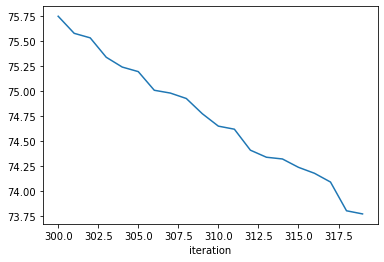

In [72]:
(importance_df.groupby('iteration').sum()['ge']*100/baseline_ge).plot()

<AxesSubplot:xlabel='iteration'>

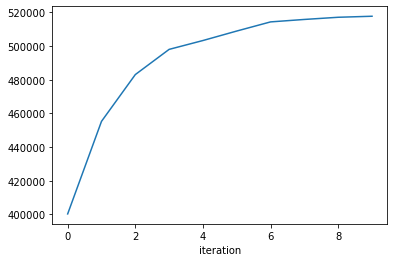

In [30]:
importance_df.groupby('iteration').sum()['travel_time'].plot()

In [31]:
importance_df.groupby('iteration').sum()

,origin,destination,travel_time,total,ge
iteration,,,,,
0,9723931,8778424,400330.0,211386,0.021865
1,9723931,8778424,455261.0,211386,0.020055
2,9723931,8778424,483039.0,211386,0.019473
3,9723931,8778424,498003.0,211386,0.019131
4,9723931,8778424,503257.0,211386,0.018975
5,9723931,8778424,508890.0,211386,0.018781
6,9723931,8778424,514315.0,211386,0.018657
7,9723931,8778424,515768.0,211386,0.018608
8,9723931,8778424,517061.0,211386,0.018566


# Individual Iterations

In [371]:
G_copy = G.copy()

In [372]:
bc_weighted

,INT_ID_o,INT_ID_d,route,weighted,type
0,106,105,1.0,1.477083e-08,raw_am
1,105,104,1.0,1.418664e-08,raw_am
2,218,217,2.0,1.156116e-08,raw_am
3,217,216,2.0,1.135727e-08,raw_am
4,104,103,1.0,1.111271e-08,raw_am
...,...,...,...,...,...
9739,20364357,13441651,102.0,1.488503e-14,raw_am
9740,13441776,13441912,102.0,1.488503e-14,raw_am
9741,13441683,13441776,102.0,1.488503e-14,raw_am
9742,13441912,13442251,102.0,1.488503e-14,raw_am


In [373]:
edge_pairs = bc_weighted.head(2000).merge(stop_times_od).merge(node_df[['node_id', 'index']], left_on = ['node_o'], right_on = 'node_id')
edge_pairs

,INT_ID_o,INT_ID_d,route,weighted,type,node_o,node_d,node_id,index
0,106,105,1.0,1.477083e-08,raw_am,106-1-9-22,105-1-9-23,106-1-9-22,2341583
1,106,105,1.0,1.477083e-08,raw_am,106-1-9-24,105-1-9-26,106-1-9-24,2341613
2,106,105,1.0,1.477083e-08,raw_am,106-1-9-26,105-1-9-28,106-1-9-26,2341644
3,106,107,1.0,3.608114e-09,raw_am,106-1-9-26,107-1-9-27,106-1-9-26,2341644
4,106,105,1.0,1.477083e-08,raw_am,106-1-9-29,105-1-9-30,106-1-9-29,2341674
...,...,...,...,...,...,...,...,...,...
223517,13447015,13446954,95.0,1.584948e-10,raw_am,13447015-95-17-46,13446954-95-17-46,13447015-95-17-46,2950525
223518,13447015,13446954,95.0,1.584948e-10,raw_am,13447015-95-17-54,13446954-95-17-54,13447015-95-17-54,2950576
223519,13447015,13446954,95.0,1.584948e-10,raw_am,13447015-95-15-20,13446954-95-15-20,13447015-95-15-20,2951521
223520,13447015,13446954,95.0,1.584948e-10,raw_am,13447015-95-15-37,13446954-95-15-37,13447015-95-15-37,2951583


In [374]:
# edge_pairs = stop_times_od.merge(node_df[['node_id', 'index']], left_on = ['node_o'], right_on = 'node_id')
# edge_pairs

In [375]:

edge_pairs = edge_pairs.rename(columns = {'index': 'index_o'})
edge_pairs = edge_pairs.drop(columns = ['node_id'])
edge_pairs = edge_pairs.merge(node_df[['node_id', 'index']], left_on = ['node_d'], right_on = 'node_id')
edge_pairs = edge_pairs.rename(columns = {'index': 'index_d'})
edge_pairs = edge_pairs.drop(columns = ['node_id'])
edge_pairs

,INT_ID_o,INT_ID_d,route,weighted,type,node_o,node_d,index_o,index_d
0,106,105,1.0,1.477083e-08,raw_am,106-1-9-22,105-1-9-23,2341583,2341584
1,106,105,1.0,1.477083e-08,raw_am,106-1-9-24,105-1-9-26,2341613,2341614
2,104,105,1.0,1.592076e-09,raw_am,104-1-9-25,105-1-9-26,2341585,2341614
3,106,105,1.0,1.477083e-08,raw_am,106-1-9-26,105-1-9-28,2341644,2341645
4,106,107,1.0,3.608114e-09,raw_am,106-1-9-26,107-1-9-27,2341644,2341673
...,...,...,...,...,...,...,...,...,...
223517,13447015,13446954,95.0,1.584948e-10,raw_am,13447015-95-17-37,13446954-95-17-37,2950463,2950464
223518,13447015,13446954,95.0,1.584948e-10,raw_am,13447015-95-17-46,13446954-95-17-46,2950525,2950526
223519,13447015,13446954,95.0,1.584948e-10,raw_am,13447015-95-17-54,13446954-95-17-54,2950576,2950577
223520,13447015,13446954,95.0,1.584948e-10,raw_am,13447015-95-15-20,13446954-95-15-20,2951521,2951522


In [376]:
G_copy.vcount(), G_copy.ecount()

(3643798, 31119909)

In [377]:
del_edge = G.get_eids(edge_pairs[['index_o', 'index_d']].values.tolist(), directed = True)

In [378]:
G_copy.delete_edges(del_edge)

In [379]:
G_copy.vcount(), G_copy.ecount()

(3643798, 30897920)

In [380]:
# G_copy.delete_vertices(19800)

In [381]:
%%time
node_key_table = []

for i in G_copy.vs:
    node_key_table.append([i.index,  i['id']])
node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0]

o_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['o_node'])]['index'])
d_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['d_node'])]['index'])

Wall time: 19.1 s


In [ ]:
%%time

out_all = G_copy.shortest_paths(o_list_new, d_list_new, weights = 'cost',  mode = 'out')
table = []
for i in range(len(o_list_new)):
    temp_lst = out_all[i]
    for j in range(len(d_list_new)):
        table.append([o_list_new[i], d_list_new[j], temp_lst[j], iteration])

temp_df = pd.DataFrame.from_records(table, columns = ['index_o', 'index_d', 'travel_time', 'iteration'])
temp_df = temp_df.merge(node_df_new[['node_id', 'index', 'INT_ID']], left_on = ['index_o'], right_on = ['index'])
temp_df = temp_df.rename(columns = {'node_id':'o_node', 'INT_ID':'origin'})[['o_node', 'index_d', 'origin','travel_time', 'iteration']]
temp_df = temp_df.merge(node_df_new[['node_id', 'index','INT_ID']], left_on = ['index_d'], right_on = ['index'])
temp_df = temp_df.rename(columns = {'node_id':'d_node','INT_ID':'destination'})[['o_node', 'd_node', 'origin','destination','travel_time', 'iteration']]
temp_df = temp_df.merge(node_data[['o_node', 'd_node']])
temp_df['origin'] = temp_df['origin'].astype(int)
temp_df['destination'] = temp_df['destination'].astype(int)
temp_df = temp_df[temp_df['origin'] != temp_df['destination']]

In [ ]:
temp_df

In [ ]:
temp_df = temp_df.merge(od_data)
temp_df['ge'] =  (1/temp_df['travel_time'])*(temp_df['total']/total_trips)
new_ge = temp_df['ge'].sum()
new_ge

In [ ]:
new_ge/baseline_ge*100

In [293]:
temp_df['status'] = True

In [294]:
check_diff = importance_df.merge(temp_df[['o_node', 'd_node', 'status', 'travel_time']], left_on = ['o_node', 'd_node'],
                                 right_on = ['o_node', 'd_node'],how = 'left')
check_diff['delta'] = check_diff['travel_time_y'] - check_diff['travel_time_x']

In [295]:
check_diff.sort_values(by = 'delta')

,o_node,d_node,origin,destination,travel_time_x,iteration,type,total,ge,status,travel_time_y,delta
5446,1538-0-7-59,1252-0-99-99,1538,1252,29.0,0,raw_am,17,2.767124e-06,True,29.0,0.0
6732,1478-0-7-59,1470-0-99-99,1478,1470,20.0,0,raw_am,12,2.832233e-06,True,20.0,0.0
6079,1385-0-7-59,1383-0-99-99,1385,1383,20.0,0,raw_am,13,3.068252e-06,True,20.0,0.0
7117,1538-0-7-59,1542-0-99-99,1538,1542,22.0,0,raw_am,41,8.797086e-06,True,22.0,0.0
1796,1067-0-7-59,1054-0-99-99,1067,1054,18.0,0,raw_am,38,9.965263e-06,True,18.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2673,1177-0-7-59,1059-0-99-99,1177,1059,41.0,0,raw_am,19,2.187497e-06,True,inf,inf
2672,1153-0-7-59,1059-0-99-99,1153,1059,63.0,0,raw_am,20,1.498536e-06,True,inf,inf
2671,1150-0-7-59,1059-0-99-99,1150,1059,63.0,0,raw_am,296,2.217833e-05,True,inf,inf
2669,1130-0-7-59,1059-0-99-99,1130,1059,65.0,0,raw_am,8,5.809708e-07,True,inf,inf


In [300]:
check_diff[check_diff['travel_time_y'] !=np.inf].sort_values(by = 'travel_time_y').tail(5)

,o_node,d_node,origin,destination,travel_time_x,iteration,type,total,ge,status,travel_time_y,delta
2852,1483-0-7-59,1063-0-99-99,1483,1063,65.0,0,raw_am,12,8.714562e-07,True,604.0,539.0
2941,1243-0-7-59,1065-0-99-99,1243,1065,53.0,0,raw_am,10,8.906392e-07,True,605.0,552.0
2938,1234-0-7-59,1065-0-99-99,1234,1065,74.0,0,raw_am,19,1.211991e-06,True,605.0,531.0
3011,1483-0-7-59,1065-0-99-99,1483,1065,67.0,0,raw_am,15,1.056803e-06,True,605.0,538.0
2940,1239-0-7-59,1065-0-99-99,1239,1065,81.0,0,raw_am,16,9.324223e-07,True,605.0,524.0


In [60]:
G_copy = G.copy()
for i in G_copy.vs:
    node_key_table.append([i.index,  i['id']])
node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])
node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0].astype(int)

In [61]:
node_df_new[node_df_new['node_id']=='1624-0-7-59']

,index,node_id,INT_ID
3632672,3632672,1624-0-7-59,1624


In [66]:
G_copy = G.copy()

edge_pairs = bc_weighted.head(2000).merge(stop_times_od).merge(node_df_new[['node_id', 'index']], left_on = ['node_o'], right_on = 'node_id')

edge_pairs = edge_pairs.rename(columns = {'index': 'index_o'})
edge_pairs = edge_pairs.drop(columns = ['node_id'])
edge_pairs = edge_pairs.merge(node_df_new[['node_id', 'index']], left_on = ['node_d'], right_on = 'node_id')
edge_pairs = edge_pairs.rename(columns = {'index': 'index_d'})
edge_pairs = edge_pairs.drop(columns = ['node_id'])

del_edge = G.get_eids(edge_pairs[['index_o', 'index_d']].values.tolist(), directed = True)
G_copy.delete_edges(del_edge)
node_key_table = []
for i in G_copy.vs:
    node_key_table.append([i.index,  i['id']])
node_df1 = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])
node_df1['INT_ID'] = node_df1['node_id'].str.split('-', expand = True)[0].astype(int)


In [67]:
node_df1[node_df1['node_id']=='1624-0-7-59']

,index,node_id,INT_ID
3632672,3632672,1624-0-7-59,1624


In [261]:
node_df_new[node_df_new['node_id']=='1371-0-99-99']

,index,node_id,INT_ID
3635621,3635621,1371-0-99-99,1371


In [303]:
check_diff['travel_time_y'] = np.where(check_diff['travel_time_y'] == np.inf, 600, check_diff['travel_time_y'])

<AxesSubplot:>

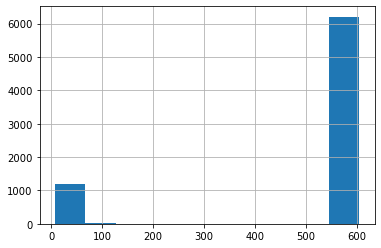

In [304]:
check_diff['travel_time_y'].hist()

In [17]:
removed_edge = 0
iteration = 0

while removed_edge <= len(bc_weighted):
    
    if iteration == 0:
        removed_edge = 0
    elif iteration <= 50:
        removed_edge = removed_edge + 1
        
    elif 50 < iteration <= 150:
        removed_edge = removed_edge + 5
        
    elif 150 < iteration <= 250:
        removed_edge = removed_edge + 10
        
    elif 250 < iteration <= 350:
        removed_edge = removed_edge + 25 
        
    else:
        removed_edge = removed_edge + 50
        
    print(iteration,removed_edge)    
    iteration = iteration + 1
    

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 55
52 60
53 65
54 70
55 75
56 80
57 85
58 90
59 95
60 100
61 105
62 110
63 115
64 120
65 125
66 130
67 135
68 140
69 145
70 150
71 155
72 160
73 165
74 170
75 175
76 180
77 185
78 190
79 195
80 200
81 205
82 210
83 215
84 220
85 225
86 230
87 235
88 240
89 245
90 250
91 255
92 260
93 265
94 270
95 275
96 280
97 285
98 290
99 295
100 300
101 305
102 310
103 315
104 320
105 325
106 330
107 335
108 340
109 345
110 350
111 355
112 360
113 365
114 370
115 375
116 380
117 385
118 390
119 395
120 400
121 405
122 410
123 415
124 420
125 425
126 430
127 435
128 440
129 445
130 450
131 455
132 460
133 465
134 470
135 475
136 480
137 485
138 490
139 495
140 500
141 505
142 510
143 515
144 520
145 525
146 530
147 

In [12]:
iteration

464

In [9]:
bc_weighted.head(10000)

,INT_ID_o,INT_ID_d,route,weighted,type
0,106,105,1.0,1.477083e-08,raw_am
1,105,104,1.0,1.418664e-08,raw_am
2,218,217,2.0,1.156116e-08,raw_am
3,217,216,2.0,1.135727e-08,raw_am
4,104,103,1.0,1.111271e-08,raw_am
...,...,...,...,...,...
9739,20364357,13441651,102.0,1.488503e-14,raw_am
9740,13441776,13441912,102.0,1.488503e-14,raw_am
9741,13441683,13441776,102.0,1.488503e-14,raw_am
9742,13441912,13442251,102.0,1.488503e-14,raw_am


In [8]:
bc_weighted

,INT_ID_o,INT_ID_d,route,weighted,type
0,106,105,1.0,1.477083e-08,raw_am
1,105,104,1.0,1.418664e-08,raw_am
2,218,217,2.0,1.156116e-08,raw_am
3,217,216,2.0,1.135727e-08,raw_am
4,104,103,1.0,1.111271e-08,raw_am
...,...,...,...,...,...
9739,20364357,13441651,102.0,1.488503e-14,raw_am
9740,13441776,13441912,102.0,1.488503e-14,raw_am
9741,13441683,13441776,102.0,1.488503e-14,raw_am
9742,13441912,13442251,102.0,1.488503e-14,raw_am
